Loading cached camera calibration... Done.


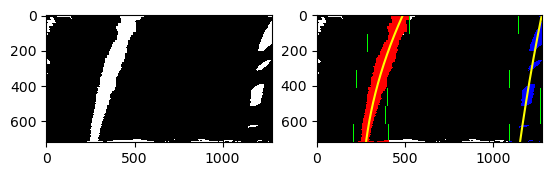

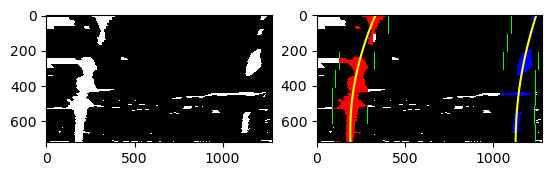

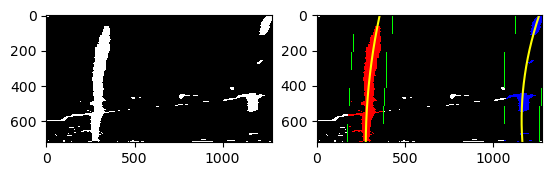

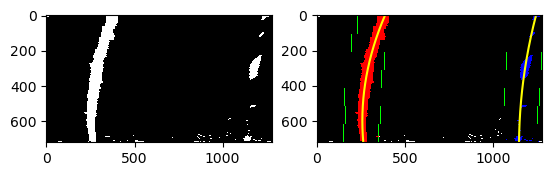

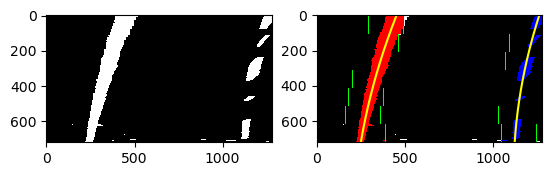

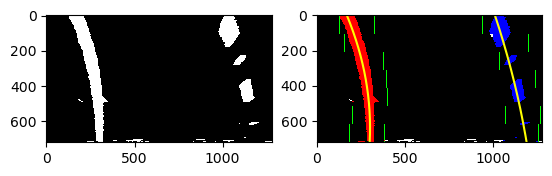

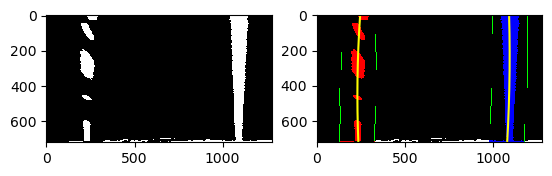

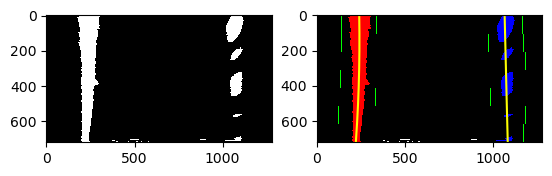

In [4]:
import numpy as np
import cv2
import glob
import collections
import matplotlib.pyplot as plt
from calibration_utils import calibrate_camera, undistort
from binarization_utils import binarize
from perspective_utils import birdeye


ym_per_pix = 30 / 720   # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

time_window = 10        # results are averaged over this number of frames



class Line:
    """
    Class to model a lane-line.
    """
    def __init__(self, buffer_len=10):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None

    def update_line(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        """
        Update Line with new fitted coefficients.

        :param new_fit_pixel: new polynomial coefficients (pixel)
        :param new_fit_meter: new polynomial coefficients (meter)
        :param detected: if the Line was detected or inferred
        :param clear_buffer: if True, reset state
        :return: None
        """
        self.detected = detected

        if clear_buffer:
            self.recent_fits_pixel = []
            self.recent_fits_meter = []

        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter

        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)

    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.last_fit_pixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

    @property
    # average of polynomial coefficients of the last N iterations
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)

    @property
    # radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

    @property
    # radius of curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])


def get_fits_by_sliding_windows(birdeye_binary, line_lt, line_rt, n_windows=9, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.

    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param n_windows: number of sliding windows used to search for the lines
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """
    height, width = birdeye_binary.shape

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary[height//2:-30, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = len(histogram) // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(height / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100  # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if verbose:
        f, ax = plt.subplots(1, 2)
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)

        plt.show()

    return line_lt, line_rt, out_img


def get_fits_by_previous_fits(birdeye_binary, line_lt, line_rt, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    This function starts from previously detected lane-lines to speed-up the search of lane-lines in the current frame.

    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """

    height, width = birdeye_binary.shape

    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel

    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    # Create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    window_img = np.zeros_like(img_fit)

    # Color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)

    if verbose:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()

    return line_lt, line_rt, img_fit


def draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    """
    Draw both the drivable lane area and the detected lane-lines onto the original (undistorted) frame.
    :param img_undistorted: original undistorted color frame
    :param Minv: (inverse) perspective transform matrix used to re-project on original frame
    :param line_lt: left lane-line previously detected
    :param line_rt: right lane-line previously detected
    :param keep_state: if True, line state is maintained
    :return: color blend
    """
    height, width, _ = img_undistorted.shape

    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(0, 0, 255), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)

    return blend_onto_road


if __name__ == '__main__':

    line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)

    ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images_dir='camera_cal')

    # show result on test images
    for test_img in glob.glob('test_images/*.jpg'):

        img = cv2.imread(test_img)

        img_undistorted = undistort(img, mtx, dist, verbose=False)

        img_binary = binarize(img_undistorted, verbose=False)

        img_birdeye, M, Minv = birdeye(img_binary, verbose=False)

        line_lt, line_rt, img_out = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, verbose=True)








